In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import gaussian_process.regression as gpr
from gaussian_process.kernels import RBF

### 1D case

In [2]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.normal(key,x.shape)

In [3]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 2
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (9,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 5
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (1.0, 1.0)

In [4]:
model = gpr.ExactGPR(kernel,data_split,kernel_params,noise_var=noise**2)
model.train(X_data,Y_data)
(means_full, stds_full) = model.eval(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

[0.01 1.  ]
[  1.85     -10.647183]


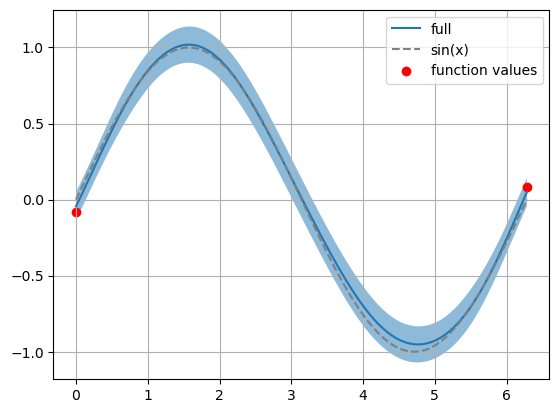

In [5]:
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-stds_full,means_full+stds_full,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

In [6]:
from jax.lax import fori_loop

def loop_body(i,val):
    temp = 5.0 - 1.0*i
    return jnp.where(val < temp, val, temp)
    if val < temp: return temp
    else: return val
    return jnp.append(val, temp)

val = 3.0
result = fori_loop(1,5,loop_body,val)
print(result)

1.0


In [7]:
print(result)

1.0


In [8]:
a = [1,2,3]
b = 4
c = []
jnp.array([*a,b,*c])

DeviceArray([1, 2, 3, 4], dtype=int32)